Before use download crashpy from https://gitlab.mpcdf.mpg.de/CRASH/crashpy and add to your $PYTHONPATH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from matplotlib.colors import LogNorm
from matplotlib import colors
from crashpy.utilities import crashMemMap
from crashpy.utilities import writeCRASHGrids
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

A bunch of trivial helper function the function get_maps needs

In [2]:
path = '/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/input/L35n2160TNG/sn013/g1757/dens_ic00.in'
dens = crashMemMap(path, 'all')

In [9]:
(8388608/4)**(1/3)

127.99999999999997

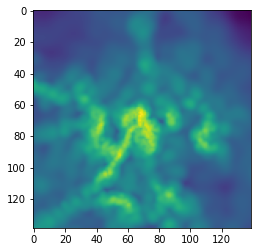

In [7]:
plt.imshow(dens[0][70,:,:], norm=LogNorm())

In [6]:
dens[0].shape

(139, 139, 139)

In [164]:
def get_simulation_paths(path_to_halo, num = 5):
    path_in_T = os.path.join(path_to_halo, 'Input/temp_ic00.in')
    path_in_ion = os.path.join(path_to_halo, 'Input/ion.in')
    path_dens = os.path.join(path_to_halo, 'Input/dens_ic00.in')
#     path_in_T = os.path.join(path_to_halo, 'temp_ic00.in')
#     path_in_ion = os.path.join(path_to_halo, 'ion.in')
#     path_dens = os.path.join(path_to_halo, 'dens_ic00.in')
    
    path_out =  os.path.join(path_to_halo, f'Output/phys_ic00_rt0{num}.out')
#     path_out = '/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/run/L35n2160TNG/sn00phys_ic00_rt05.out'
    
    return path_in_T, path_in_ion, path_dens, path_out

def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

### get_maps(path_to_halo, props=None)

**Parameters**:
- **path_to_halo**: Just the path where the halo file is located
- **props**: What maps you want returned, default is all i.e 'T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII'

**Returns**:
- **maps**: A dictionary of dictionaries with the keywords 'in', 'out' and 'dens' corresponding to the input maps and the output after radiation transfer as well as to the gas density distribution. The first two contain a dictionary where the keyword is the map property and the value is the corresponding map in form of a 3D numpy array, the third just contains the array of the density map itself.

In [165]:
def get_maps(path_to_halo, props=None, xHI_only=False, include_in=True, include_dens=True, num=5):
    if props == None:
        props = ['T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII', 'dens']
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    path_in_T, path_in_ion, path_dens, path_out = get_simulation_paths(path_to_halo, num) 
    
    if include_in:
        halo_in = crashMemMap(path_in_T, 'all')
        halo_in.extend(crashMemMap(path_in_ion, 'all'))
    if include_dens:  
        halo_dens = crashMemMap(path_dens, 'all')
    halo_out = crashMemMap(path_out, 'all')
    
    maps = {}
    maps['in'] = {}
    maps['out'] = {}
    for prop in props:
        if prop in prop_dict:
            if include_in:
                maps['in'][prop] = halo_in[prop_dict[prop]] 
            maps['out'][prop] = halo_out[prop_dict[prop]]
        elif prop == 'xHI':
            if include_in:
                maps['in'][prop] = get_H_map(halo_in)
            maps['out'][prop] = get_H_map(halo_out)
        elif prop == 'xHeI':
            if include_in:
                maps['in'][prop] = get_He_map(halo_in)
            maps['out'][prop] = get_He_map(halo_out)
        elif prop == 'dens':
            if include_dens:
                maps['dens'] = halo_dens[0]
        else:
            raise ValueError(f'The property {prop} does not exist.')
    if xHI_only:
        HI_in = (maps['in']['xHI']*maps['dens']).sum()/maps['dens'].sum()
        HI_out = (maps['out']['xHI']*maps['dens']).sum()/maps['dens'].sum()
        return HI_in, HI_out
    else:
        return maps

### Example:

In [4]:
plt.rcParams["figure.figsize"] = (10,10)

In [60]:
maps_1e5 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn008/g1029')
maps_5e6 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/run/L35n2160TNG/sn008/g1029')

In [216]:
stroemgren_1e5 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/stroemgren_1e5/run/L35n2160TNG/sn008/g1029', 
                          include_in=False, include_dens=False, props=['T'])

stroemgren_1e6 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/stroemgren_1e6/run/L35n2160TNG/sn008/g1029', 
                          include_in=False, include_dens=False, props=['T'])

stroemgren_1e7 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/stroemgren_1e7/run/L35n2160TNG/sn008/g1029', 
                          include_in=False, include_dens=False, props=['T'])

stroemgren_1e8 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/stroemgren_1e8/run/L35n2160TNG/sn008/g1029', 
                          include_in=False, include_dens=False, props=['T'])

In [ ]:
current_dir = '/ptmp/mpa/mglatzle/TNG_f_esc/e5 '
input_folder = 'input/L35n2160TNG'
input_dir = os.path.join(current_dir, input_folder)
fid_dir = '/ptmp/mpa/mglatzle/TNG_f_esc/fid2/input/L35n2160TNG'

column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']

def set_local_fesc(input_dir):
    for snap in os.listdir(input_dir):
        packets = '1.000d+06'
        snap_dir = os.path.join(input_dir, snap)
        for halo in os.listdir(snap_dir):
            try:
                print(f'Setting the packet number to {packets} in halo {halo} of snap {snap}')
                halo_dir = os.path.join(snap_dir, halo)
                sources_path = os.path.join(halo_dir, 'sources_ic00.in')

                sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
                sources.packets = packets
                sources.to_csv(sources_path, sep='\t', header=False, index=False)
            except:
                print(halo)
                continue

In [708]:
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
sources_path = '/ptmp/mpa/mglatzle/TNG_f_esc/e6/input/L/sn008/g111/sources_ic00.in'
sources = pd.read_table(sources_path, delimiter='\t', names=column_names)

In [709]:
sources['Q'] = sources['Q'].str.replace('d','e').astype('float')
sources_updated = sources[sources['Q']>0.01*sources['Q'].max()]
sources_updated['Q'] = sources_updated['Q'].astype(str)

<ipython-input-709-4ed87313b8fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources_updated['Q'] = sources_updated['Q'].astype(str)


In [710]:
sources_updated.to_csv(sources_path, sep='\t', header=False, index=False)

In [666]:
sources_updated = sources[sources['Q']>0.01*sources['Q'].max()]

In [667]:
sources_updated

,x,y,z,a,Q,b,name,c,halo,d,packets,e,loc_uv,f,loc_x
1,47,47,49,NaN,0.89210,NaN,'110494014891_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
5,49,47,46,NaN,0.32040,NaN,'108418000930_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
20,45,45,47,NaN,0.02723,NaN,'108407260450_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
22,51,49,46,NaN,0.06238,NaN,'110276099780_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
27,46,48,46,NaN,0.01128,NaN,'108402210850_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
31,51,49,43,NaN,0.04081,NaN,'108360416290_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
46,47,48,48,NaN,0.08516,NaN,'110384545317_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0


In [647]:
sources['Q_new'] = df['column name'].str.replace('old character','new character')

,x,y,z,a,Q,b,name,c,halo,d,packets,e,loc_uv,f,loc_x
0,46,46,47,NaN,8.871d-04,NaN,'110287205926_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
1,47,47,49,NaN,8.921d-01,NaN,'110494014891_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
2,46,46,48,NaN,1.129d-03,NaN,'110364132888_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
3,47,47,46,NaN,7.380d-04,NaN,'108402225698_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
4,47,47,49,NaN,9.182d-04,NaN,'108400668194_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,90,34,52,NaN,3.703d-05,NaN,'108361605154_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
117,77,38,55,NaN,1.443d-05,NaN,'108361511458_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
118,78,39,49,NaN,8.557d-04,NaN,'108368825634_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0
119,44,74,20,NaN,3.409d-06,NaN,'108408473122_r65',NaN,'L35n2160TNG/sn008/g1029',NaN,1.000d+05,NaN,1.0,NaN,1.0


In [224]:
stroemgren_1e5['out']['T'].sum()/1e6
stroemgren_1e6['out']['T'].sum()/1e6
stroemgren_1e7['out']['T'].sum()/1e6
stroemgren_1e8['out']['T'].sum()/1e6

0.0331444765625

0.010636384765625

0.00788149462890625

0.007410365234375

In [248]:
single_source_1e5 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e5/run/L35n2160TNG/sn008/g1029')
single_source_1e6 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e6/run/L35n2160TNG/sn008/g1029')
single_source_recomb_1e6 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/ss_recomb_1e6/run/L35n2160TNG/sn008/g1029_temp_solve')
single_source_no_T_1e6 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/ss_recomb_1e6/run/L35n2160TNG/sn008/g1029', props='T')

single_source_1e7 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e7/run/L35n2160TNG/sn008/g1029')
single_source_1e8 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e8/run/L35n2160TNG/sn008/g1029')

In [433]:
maps_1e5_normal = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn008/g1029')
maps_1e5_source_ionized = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/source_cells_ionized_1e5/run/L35n2160TNG/sn008/g1029')
maps_5e6_normal = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/run/L35n2160TNG/sn008/g1029')
maps_1e6_source_ionized = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/source_cells_ionized_1e6/run/L35n2160TNG/sn008/g1029')

In [435]:
single_source_1e5 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e5/run/L35n2160TNG/sn008/g1029')
single_source_1e5_si = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e5_si/run/L35n2160TNG/sn008/g1029')
single_source_1e6 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e6/run/L35n2160TNG/sn008/g1029')
single_source_1e6_si = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/single_source_1e6_si/run/L35n2160TNG/sn008/g1029')

In [41]:
halo = '1029'

In [20]:
stroemgren_rc_1e7= get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/rc_crash_1e7/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T'])
stroemgren_rc_1e7_temp= get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/rc_crash_1e7_temp/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T','xHII'])
stroemgren_rc_1e6_temp= get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/rc_crash_1e6_temp/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T','xHII'])
stroemgren_rc_1e8_temp= get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/rc_crash_1e8_temp/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T','xHII'])
stroemgren_rc_2e9_temp= get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/rc_crash_2e9_temp/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T','xHII'])

In [576]:
stroemgren_b1_caseb_1e7 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/str_b1_temp_1e7_nob/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T', 'xHII'])

In [631]:
halo = '1029'

In [715]:
halo=100

In [559]:
stroemgren_marius_2e9 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/te2/run/L/sn008/g{halo}', 
                          include_in=False, include_dens=False, props=['T', 'xHII'])

In [838]:
# stroemgren_marius_2e9 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/te2/run/L/sn008/g{halo}', 
#                           include_in=False, include_dens=False, props=['T', 'xHII'])
test = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/100/run/L/sn008/g1029', 
                          include_in=False, include_dens=False, props=['T', 'xHII'])
stroemgren_552 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn013/g72', 
                          include_in=True, include_dens=False, props=['T', 'xHII'], num=4)

In [831]:
stroemgren_552['out']['xHII'].shape

(512, 512, 512)

In [839]:
stroemgren_552['in'].keys()

dict_keys(['T', 'xHII'])

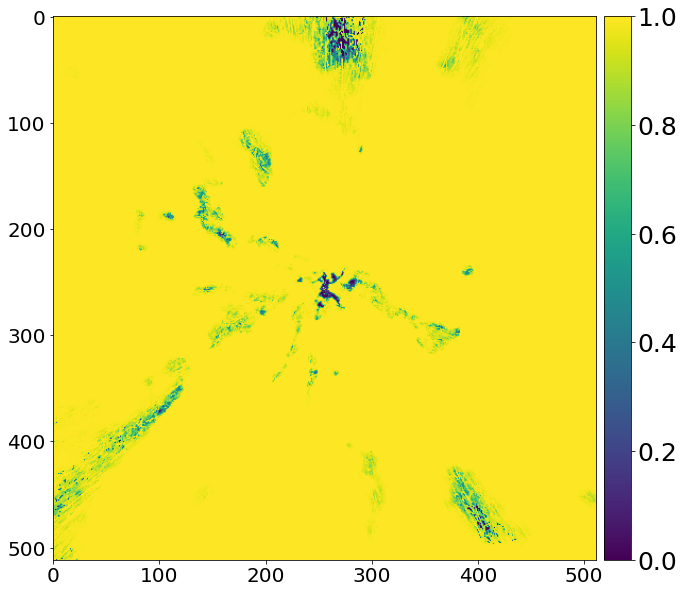

In [843]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_552['out']['xHII'][256])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

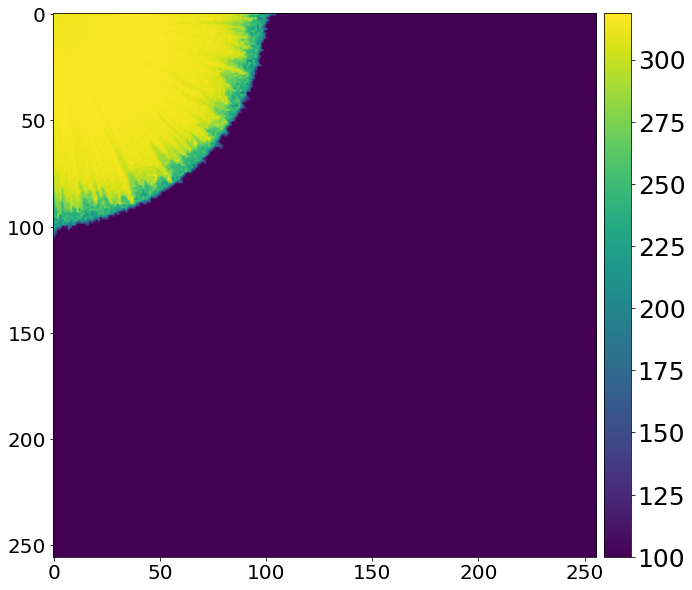

In [795]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_552['out']['T'][cut])#, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

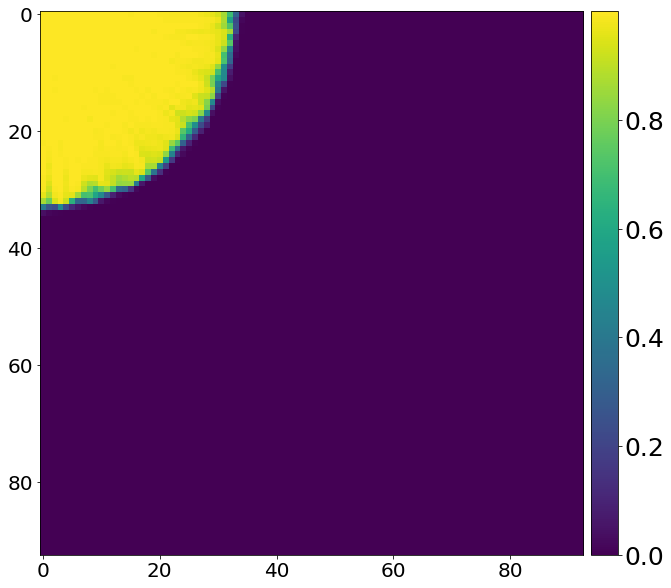

In [804]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_marius_100k_test['out']['xHII'][cut])#, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

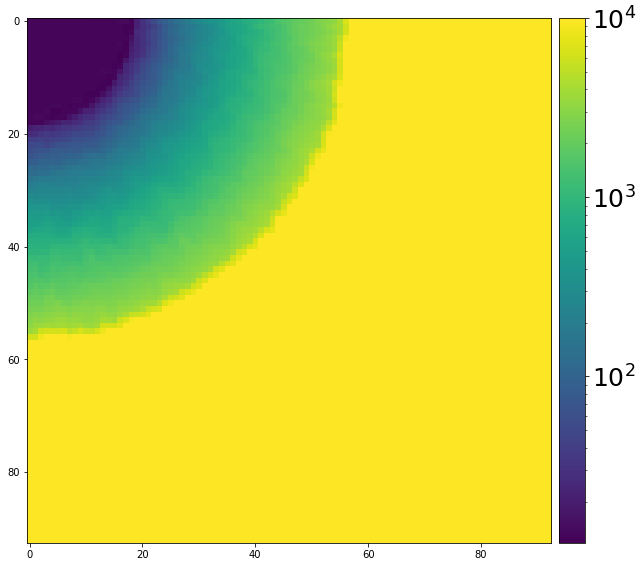

In [364]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_marius['out']['T'][cut]+1e-9, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [337]:
num=5
halo_1029_1e5 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/524__1e5/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
halo_1029_1e6 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/run/L35n2160TNG/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
halo_1029_1e7 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/1e7/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)

In [553]:
path = '/ptmp/mpa/mglatzle/TNG_f_esc/e5/input/L/sn008/g100/dens_ic00.in'
path2 = '/ptmp/mpa/mglatzle/TNG_f_esc/e5/input/L/sn008/g1029/ion.in'
halo = crashMemMap(path, 'all')
halo2 = crashMemMap(path2, 'all')

In [556]:
halo[0].shape

(93, 93, 93)

In [532]:
new_halos = []
for i in range(len(halo)):
    new_halos.append(np.copy(halo[i]))
    new_halos[i][new_halos[i]>0.99] = 0.99

In [533]:
writeCRASHGrids(path, new_halos)

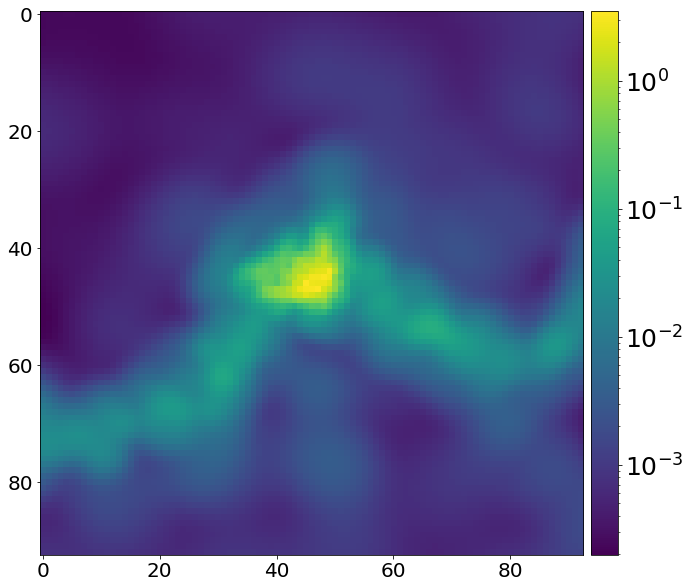

In [554]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(halo[0][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [ ]:
writeCRASHGrids(path, halo)

In [512]:
halo[0].shape
halo[1].shape
halo[2].shape/

(93, 93, 93)

(93, 93, 93)

(93, 93, 93)

IndexError: list index out of range

In [338]:
np.average(halo_1029_1e7['out']['xHII'])
np.average(halo_1029_1e6['out']['xHII'])
np.average(halo_1029_1e5['out']['xHII'])

0.902535

0.871226

0.8674233

In [454]:
Xe5 = []
Xe6 = []
Xe7 = []
for i in range(5):
    num = i+1
    halo_1029_1e5 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e5/run/L/sn008/g{halo}', 
                              include_in=True, include_dens=True, num=num)
    halo_1029_1e6 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e6/run/L/sn008/g{halo}', 
                              include_in=True, include_dens=True, num=num)
    halo_1029_1e7 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e7/run/L/sn008/g{halo}', 
                              include_in=True, include_dens=True, num=num)
        
    Xe5.append(np.average(halo_1029_1e5['out']['xHII']))
    Xe6.append(np.average(halo_1029_1e6['out']['xHII']))
    Xe7.append(np.average(halo_1029_1e7['out']['xHII']))

In [458]:
np.average(halo_1029_1e7['in']['xHII'])

0.70769274

In [434]:
fesc_T5 = [0.00083, 0.00096, 0.0012, 0.0013, 0.00085]
fesc_T6 = [0.0079, 0.026, 0.012, 0.021, 0.014]
fesc_T7 = [0.079, 0.086, 0.081, 0.078]

In [449]:
fesc_e5 = [0.00165, 0.00176, 0.00183, 0.00183, 0.00153]
fesc_e6 = [0.0126, 0.0372, 0.0159, 0.0301, 0.0227]
fesc_e7 = [0.193, 0.195, 0.204, 0.203, 0.194]
times = np.arange(2,12,2)

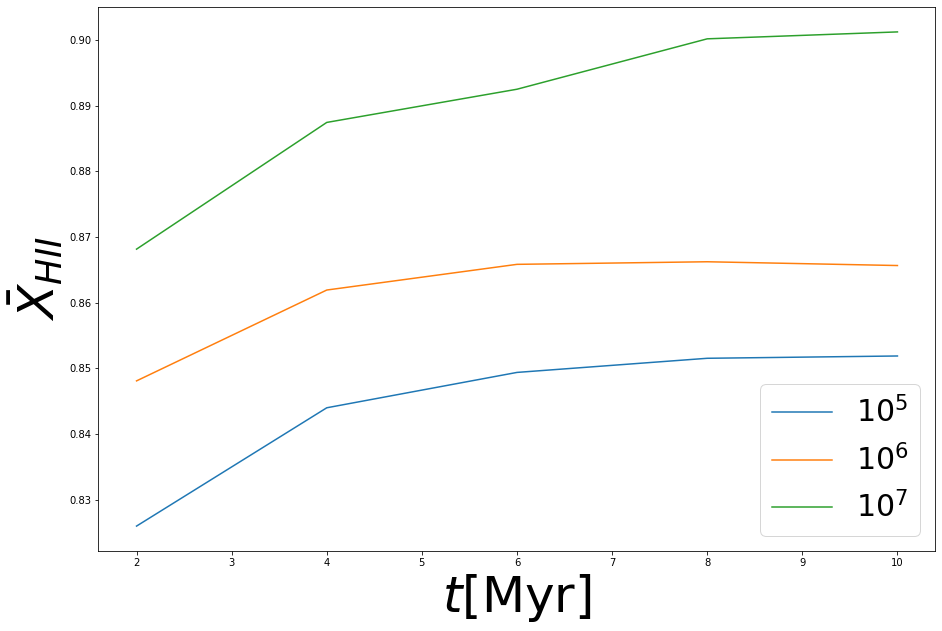

In [480]:
plt.plot(times, Xe5, label='$10^5$')
plt.plot(times, Xe6, label='$10^6$')
plt.plot(times, Xe7, label='$10^7$')
#plt.yscale('log')
tick_label_size=20
labelsize=50
x_label = '$t$[Myr]'
y_label = r'$\bar{X}_{HII}$'
#y_label = r'$f_\mathrm{esc}$'
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('xtick', labelsize=tick_label_size) 
plt.rc('ytick', labelsize=tick_label_size) 
plt.legend(fontsize=30)
plt.xlabel(x_label, fontsize=labelsize)
plt.ylabel(y_label, fontsize=labelsize);
# plt.plot(times, fesc_T5)
# plt.plot(times, fesc_T6)
# plt.plot(times[:4], fesc_T7)

In [441]:
np.average(T5['out']['T'])
np.average(T6['out']['T'])
np.average(T7['out']['T'])

0.7848988

0.78495586

0.78614813

In [810]:
halo = 111
num = 1
halo_1e5 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e5/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
halo_1e6 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e6/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
halo_1e7 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e7/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
halo_1e8 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e8/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
halo_1e9 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e9/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)

In [811]:
np.average(halo_1e5['out']['xHII'])
np.average(halo_1e6['out']['xHII'])
np.average(halo_1e7['out']['xHII'])
np.average(halo_1e8['out']['xHII'])
np.average(halo_1e9['out']['xHII'])

0.82273823

0.8377126

0.85734916

0.8688074

0.8755138

In [613]:
num = 3
halo=1029
T5_1029 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e5/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
T6_1029 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e6/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
T7_1029 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e7/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)

In [619]:
num = 3
halo=100
T5_1e3 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e5/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
T6_1e3 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e6/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
T7_1e3 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e7/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)

In [620]:
num = 3
halo=1
T5_1e2 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e5/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
T6_1e2 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e6/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)
T7_1e2 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/e7/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num)

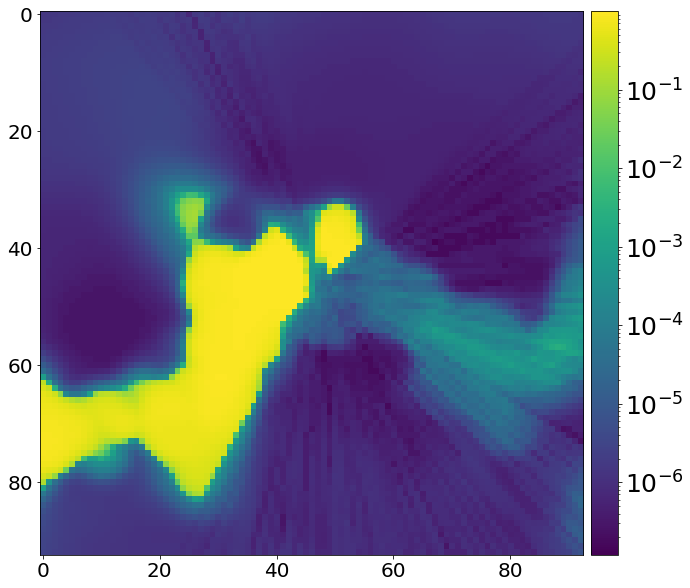

In [812]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-halo_1e8['out']['xHII'][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-824-6154393d34c7>:2: RuntimeWarning: divide by zero encountered in true_divide
  subfig = ax.imshow((1-halo_1e9['out']['xHII'][45])/(1-halo_1e6['out']['xHII'][45]), norm = LogNorm())


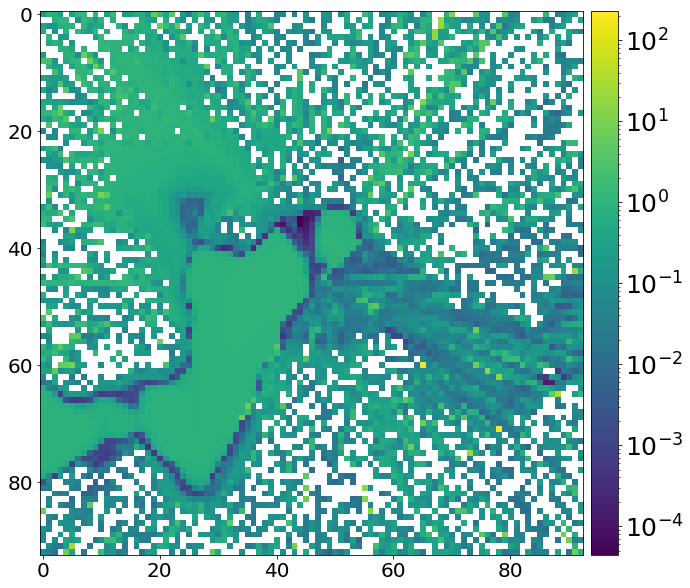

In [824]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow((1-halo_1e9['out']['xHII'][45])/(1-halo_1e6['out']['xHII'][45]), norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-630-7c9682160bb4>:1: RuntimeWarning: invalid value encountered in true_divide
  ratio = (1-T6_1029['out']['xHII'][45])/(1-T6_1e2['out']['xHII'][45])


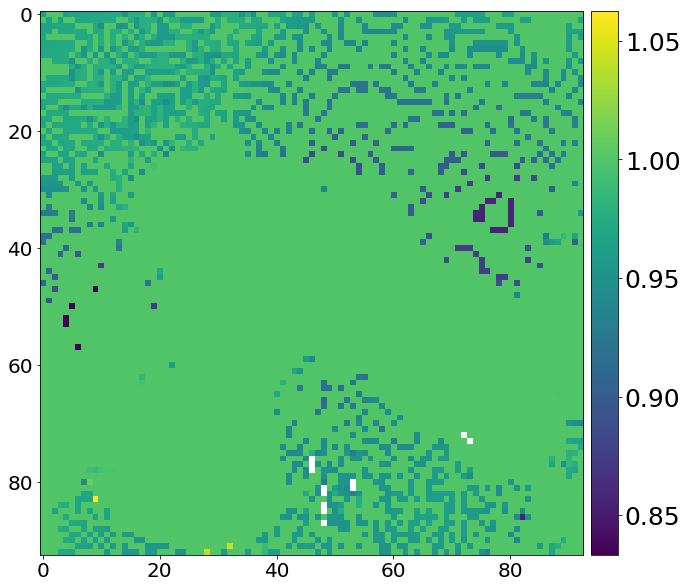

In [630]:
ratio = (1-T6_1029['out']['xHII'][45])/(1-T6_1e2['out']['xHII'][45])
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(ratio)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

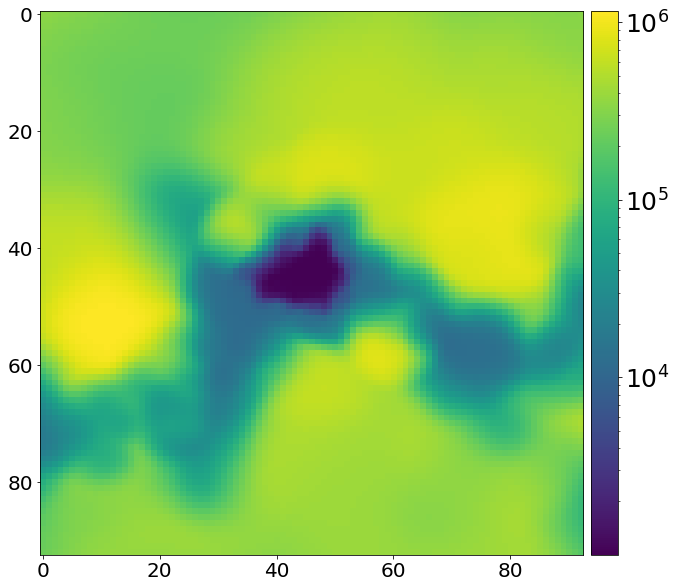

In [505]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(T6['in']['T'][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

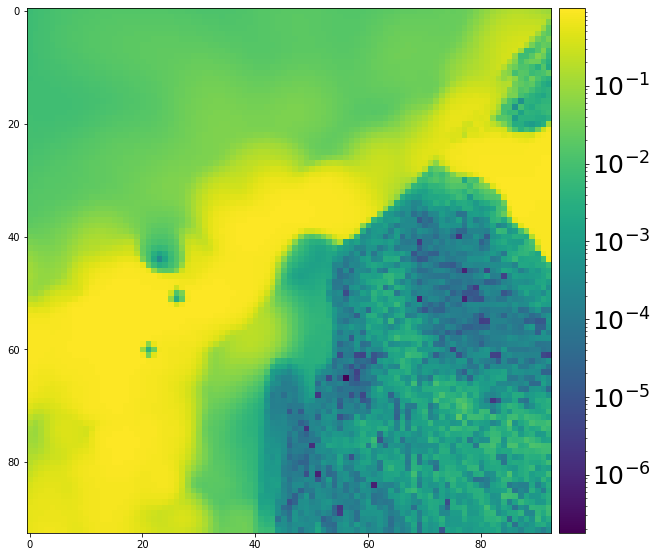

In [393]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-T7['out']['T'][70], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

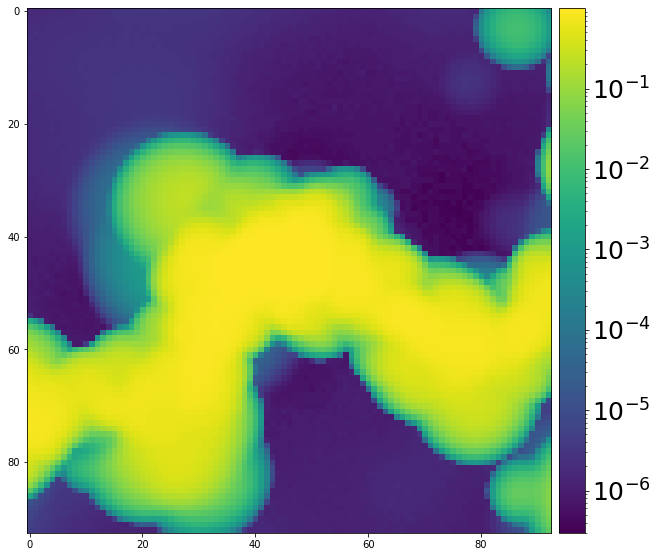

In [381]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-T7['in']['xHII'][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

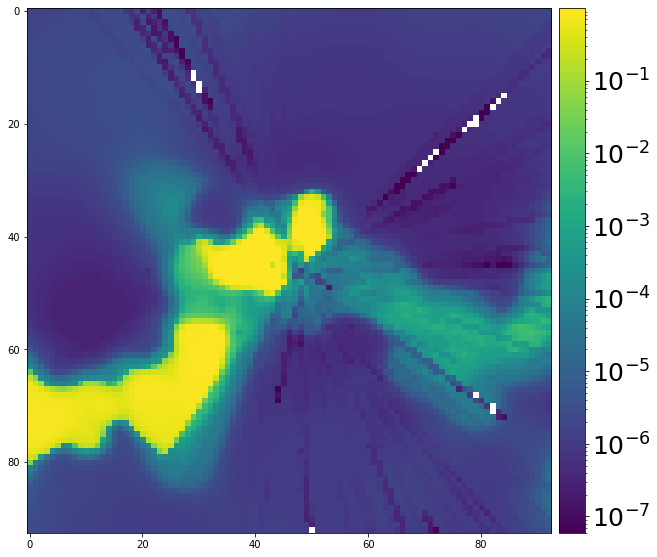

In [412]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-halo_1029_1e7['out']['xHII'][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [495]:
num=4
T5 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/T5/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num, props=['T'])
T6 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/T6/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num, props=['T'])
T7 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/T7/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=True, num=num, props=['T'])

<ipython-input-497-f1f35bad5af6>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  col_norm = colors.DivergingNorm(vmin=0.5, vcenter=1.0, vmax=2.0)


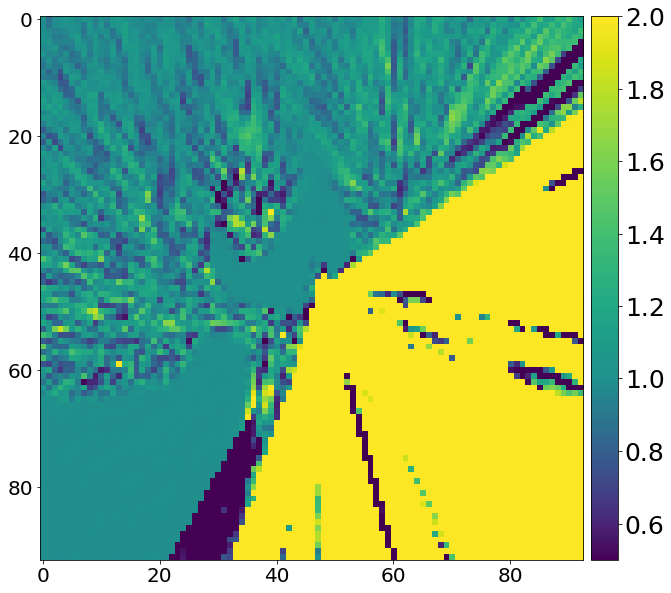

In [497]:
#ratio = (1-halo_1029_1e5['out']['xHII'][45])/((1-halo_1029_1e6['out']['xHII'][45]))
ratio = (1-T5['out']['T'][45])/((1-T7['out']['T'][45]))
#ratio = (halo_1029_1e6['out']['xHII'][45])*halo_1029_1e5['dens'][45]/((halo_1029_1e7['out']['xHII'][45])*halo_1029_1e6['dens'][45])
#ratio = np.sum((1-halo_1029_1e6['out']['xHII'])*halo_1029_1e5['dens'], axis=2)/np.sum((1-halo_1029_1e7['out']['xHII'])*halo_1029_1e6['dens'], axis=2)
f, ax = plt.subplots(1, 1)
col_norm = colors.DivergingNorm(vmin=0.5, vcenter=1.0, vmax=2.0)
subfig = ax.imshow(ratio, norm =col_norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [307]:
t5 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/T5/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=False, props=['T'], num=5)
t6 = get_maps(f'/ptmp/mpa/mglatzle/TNG_f_esc/T6/run/L/sn008/g{halo}', 
                          include_in=True, include_dens=False, props=['T'], num=5)

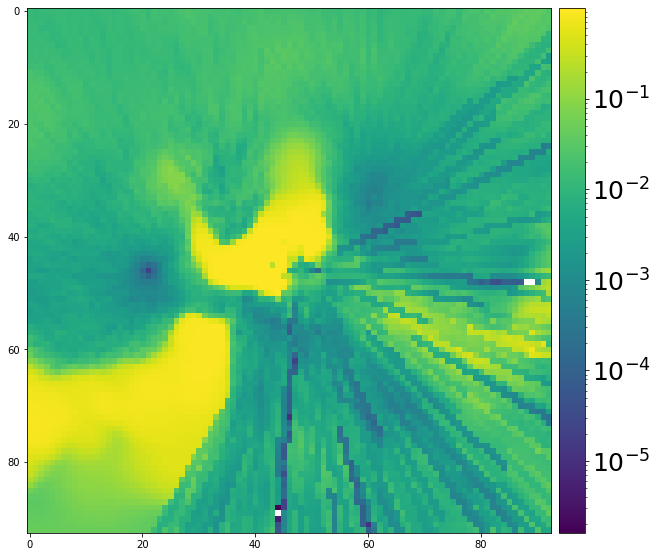

In [308]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-t5['out']['T'][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

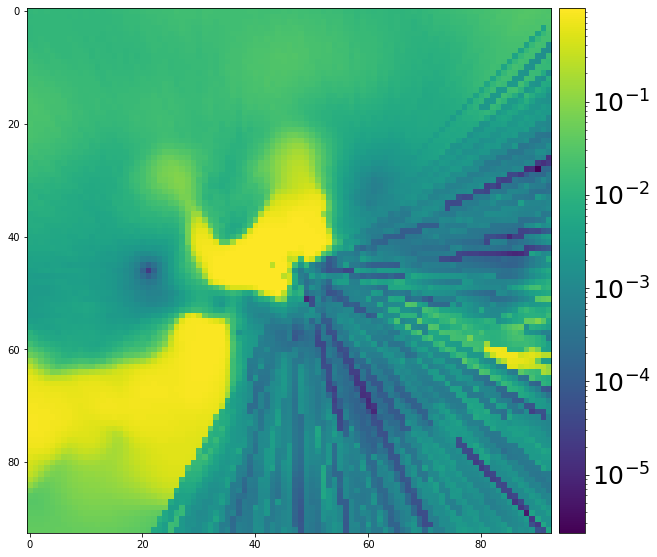

In [309]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-t6['out']['T'][45], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

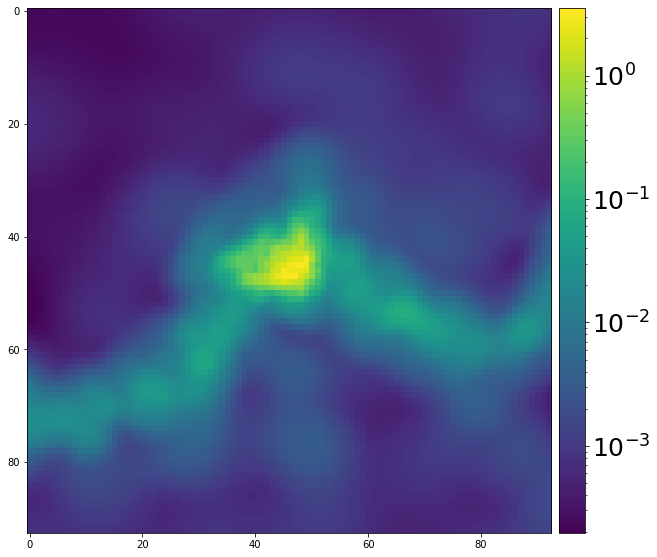

In [148]:
#ratio =  halo_1029_1e5['dens'][45]
#ratio = (1-halo_1029_1e5['out']['xHII'][45])/((1-halo_1029_1e6['out']['xHII'][45]))
#ratio = (1-halo_1029_1e5['out']['xHII'][45])*halo_1029_1e5['dens'][45]/((1-halo_1029_1e6['out']['xHII'][45])*halo_1029_1e6['dens'][45])
#ratio = np.sum((1-halo_1029_1e5['out']['xHII'])*halo_1029_1e5['dens'], axis=2)/np.sum((1-halo_1029_1e6['out']['xHII'])*halo_1029_1e6['dens'], axis=2)
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(ratio, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

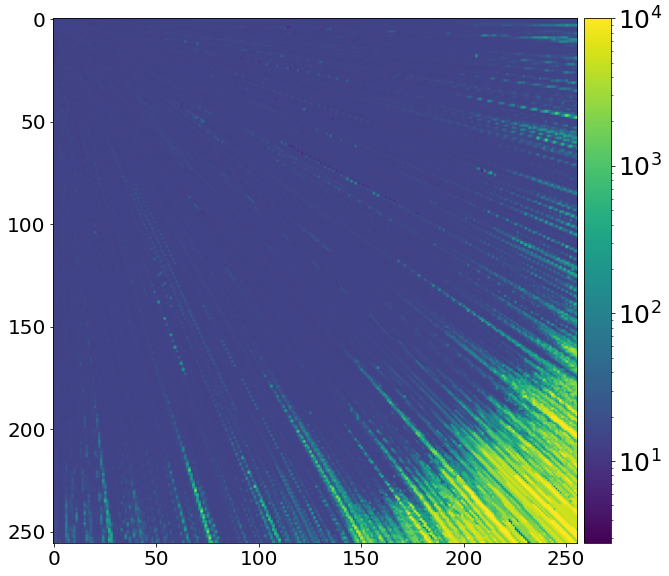

In [562]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_b1_test_1e7['out']['T'][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

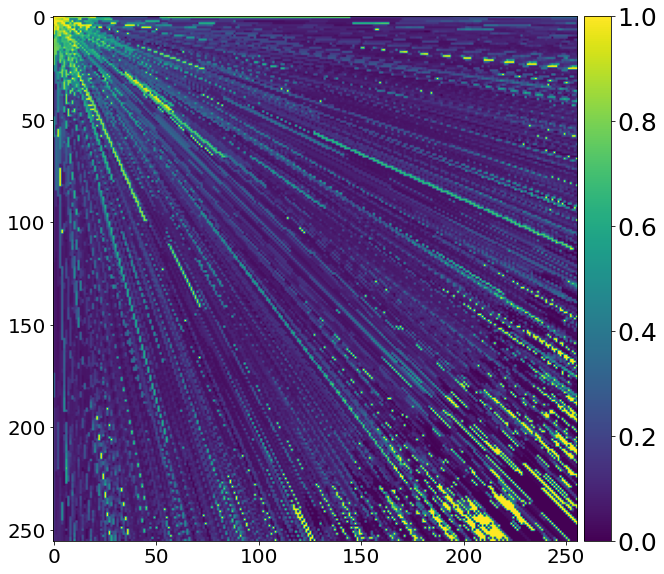

In [575]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow()#, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-581-a5bb71e033d6>:2: RuntimeWarning: divide by zero encountered in true_divide
  subfig = ax.imshow(stroemgren_b1_temp_1e7['out']['xHII'][cut]/stroemgren_b1_caseb_1e7['out']['xHII'][cut], norm = LogNorm())
<ipython-input-581-a5bb71e033d6>:2: RuntimeWarning: invalid value encountered in true_divide
  subfig = ax.imshow(stroemgren_b1_temp_1e7['out']['xHII'][cut]/stroemgren_b1_caseb_1e7['out']['xHII'][cut], norm = LogNorm())


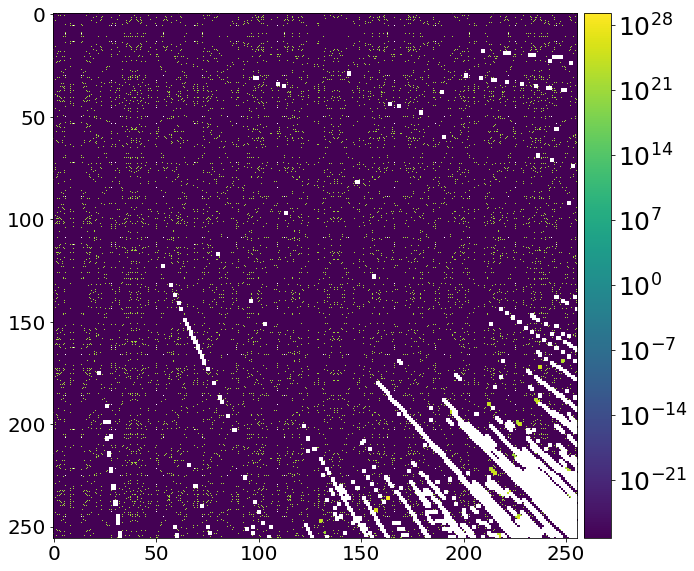

In [581]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_b1_temp_1e7['out']['xHII'][cut]/stroemgren_b1_caseb_1e7['out']['xHII'][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [347]:
stroemgren_b1_temp_2e9['out']['xHII'][200,200,200]

0.0

In [433]:
def rad_ion_fraction(ion_map):
    rad_ion = {}
    counter = 0
    for i in range(ion_map.shape[0]):
        for j in range(ion_map.shape[1]):
            for k in range(ion_map.shape[2]):
                key = np.round(np.sqrt(i**2+j**2+k**2))
                if key in rad_ion:
                    rad_ion[key][0] += 1
                    rad_ion[key][1] += ion_map[i,j,k]
                else:
                    rad_ion[key] = [1, ion_map[i,j,k]]
#                 counter += 1
#                 if counter % 1e6 == 0:
#                     print(counter)
    radii = []
    ion_frac = []
    for key in rad_ion.keys():
        radii.append(key)
        ion_frac.append(rad_ion[key][1]/rad_ion[key][0])
    radii, ion_frac = zip(*sorted(zip(radii, ion_frac)))
    return radii, ion_frac

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000


In [513]:
radii_2e9, ion_frac_2e9 = rad_ion_fraction(stroemgren_b1_2e9['out']['T'])
radii_1e6, ion_frac_1e6 = rad_ion_fraction(stroemgren_b1_1e6['out']['T'])
radii_1e7, ion_frac_1e7 = rad_ion_fraction(stroemgren_b1_1e7['out']['T'])
radii_1e8, ion_frac_1e8 = rad_ion_fraction(stroemgren_b1_1e8['out']['T'])

In [514]:
radii_temp_1e6, ion_frac_temp_1e6 = rad_ion_fraction(stroemgren_b1_temp_1e6['out']['xHII'])
radii_temp_1e7, ion_frac_temp_1e7 = rad_ion_fraction(stroemgren_b1_temp_1e7['out']['xHII'])
radii_temp_1e8, ion_frac_temp_1e8 = rad_ion_fraction(stroemgren_b1_temp_1e8['out']['xHII'])
radii_temp_2e9, ion_frac_temp_2e9 = rad_ion_fraction(stroemgren_b1_temp_2e9['out']['xHII'])

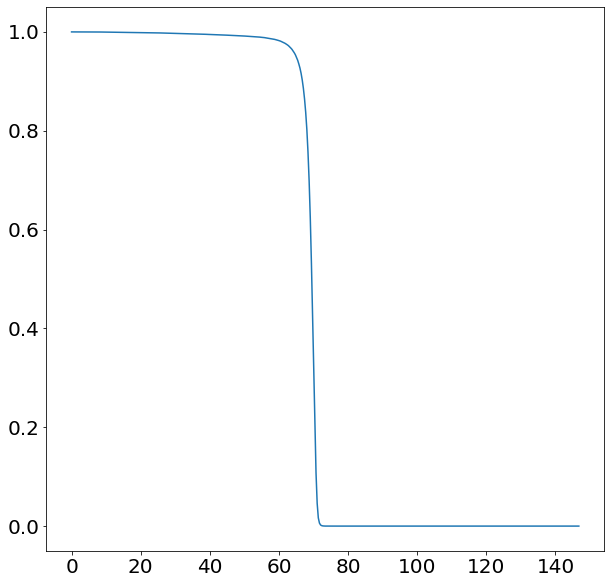

In [449]:
plt.plot(np.array(radii)*85/256, ion_frac)

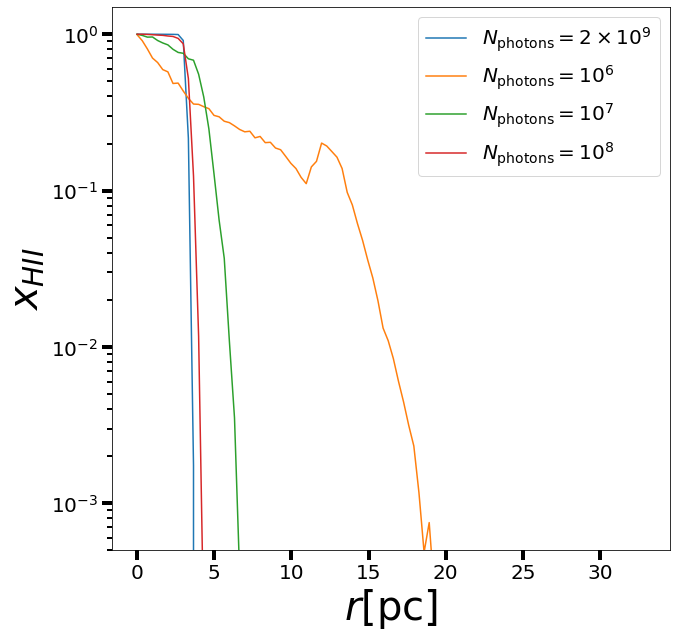

In [516]:
plt.plot(np.array(radii_2e9[:100])*85/256, ion_frac_2e9[:100], label=r'$N_{\mathrm{photons}}=2 \times 10^9$')
plt.plot(np.array(radii_1e6[:100])*85/256, ion_frac_1e6[:100], label='$N_{\mathrm{photons}}=10^6$')
plt.plot(np.array(radii_1e7[:100])*85/256, ion_frac_1e7[:100], label='$N_{\mathrm{photons}}=10^7$')
plt.plot(np.array(radii_1e8[:100])*85/256, ion_frac_1e8[:100], label='$N_{\mathrm{photons}}=10^8$')
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(5e-4,1.5)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.tick_params(length=10, width=4)
plt.tick_params(length=5, width=2, which='minor')
plt.ylabel('$x_{HII}$', size = 40)
plt.xlabel('$r[\mathrm{pc}]$', size = 40);

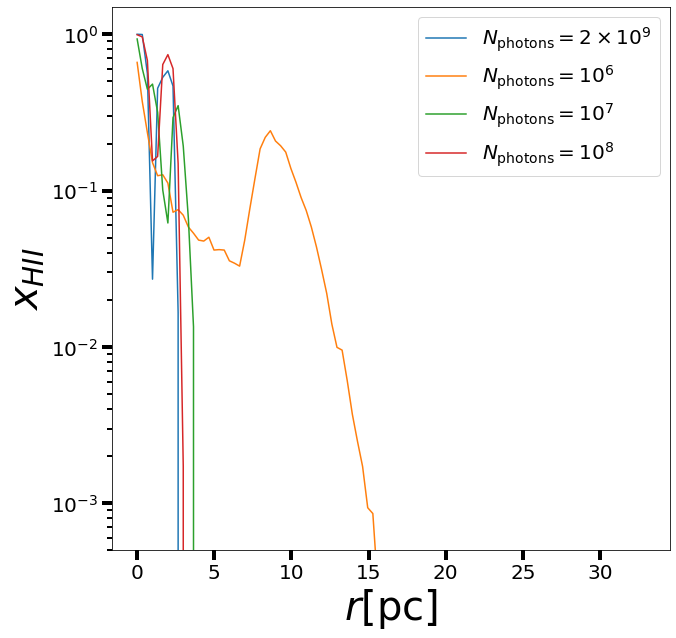

In [517]:
plt.plot(np.array(radii_temp_2e9)[:100]*85/256, ion_frac_temp_2e9[:100], label=r'$N_{\mathrm{photons}}=2 \times 10^9$')
plt.plot(np.array(radii_temp_1e6)[:100]*85/256, ion_frac_temp_1e6[:100], label='$N_{\mathrm{photons}}=10^6$')
plt.plot(np.array(radii_temp_1e7)[:100]*85/256, ion_frac_temp_1e7[:100], label='$N_{\mathrm{photons}}=10^7$')
plt.plot(np.array(radii_temp_1e8)[:100]*85/256, ion_frac_temp_1e8[:100], label='$N_{\mathrm{photons}}=10^8$')
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(5e-4,1.5)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.tick_params(length=10, width=4)
plt.tick_params(length=5, width=2, which='minor')
plt.ylabel('$x_{HII}$', size = 40)
plt.xlabel('$r[\mathrm{pc}]$', size = 40);

In [348]:
test = {3:5, 4:7, 2:1, 8:14}

In [377]:
x = []
y = []
for key in test.keys():
    x.append(key)
    y.append(test[key])

In [378]:
a, b = zip(*sorted(zip(x, y)))
print(a)

(2, 3, 4, 8)


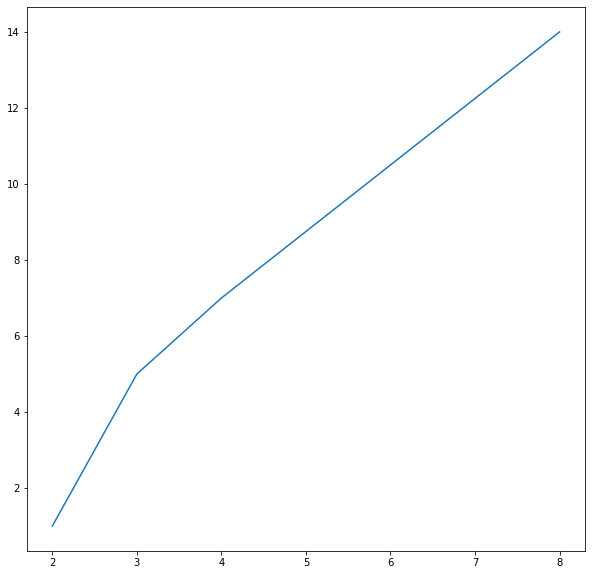

In [366]:
x,y = zip(*sorted(zip(x, y)))
plt.plot(x,y)

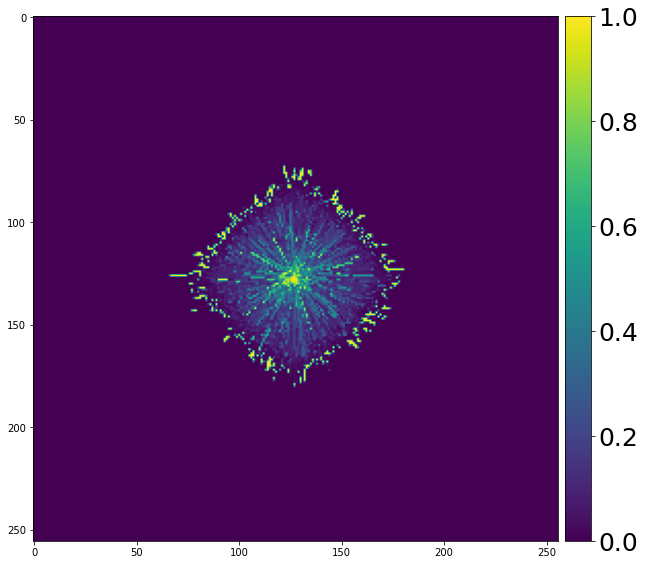

In [296]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_b1['out'][prop][cut])#, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

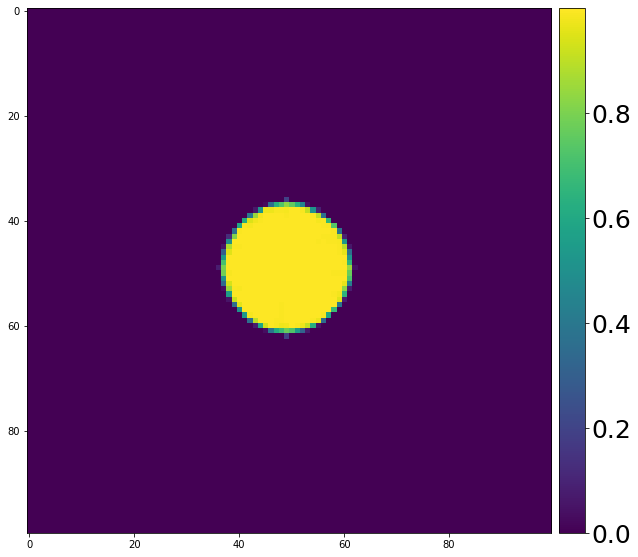

In [223]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(stroemgren_1e8['out'][prop][cut])#, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [236]:
prop = 'xHII'
cut=45

In [416]:
single_source_1e5['out'].keys()

dict_keys(['T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII'])

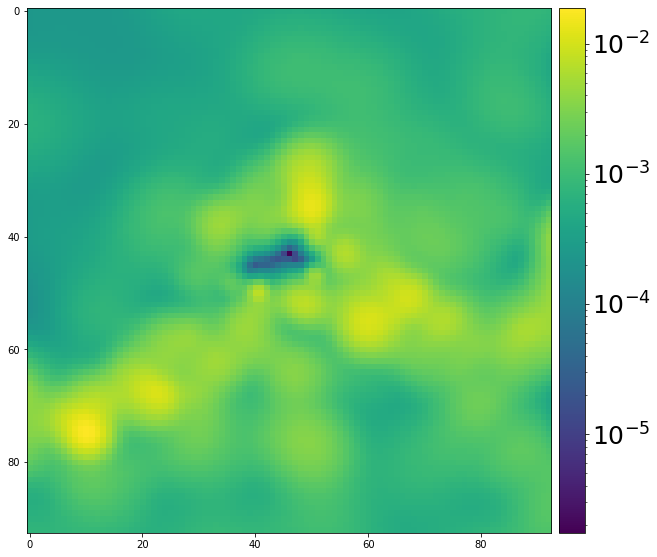

In [47]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(single_source_1e5['in'][prop][cut]*maps_1e5['dens'][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

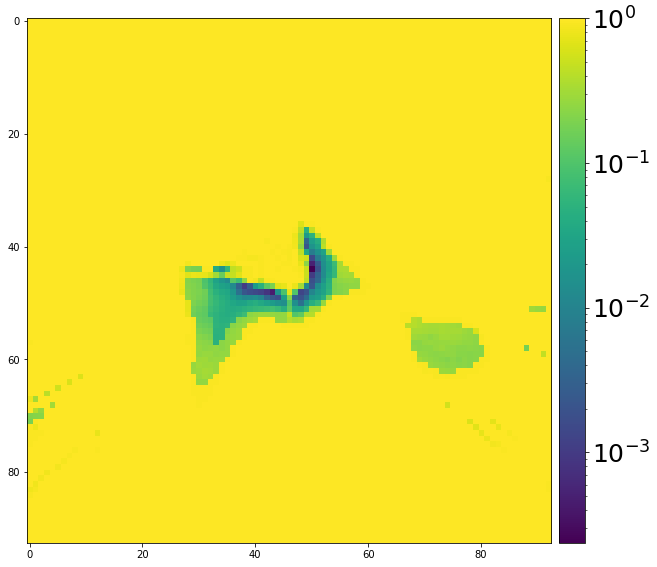

In [237]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(single_source_1e5_si['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

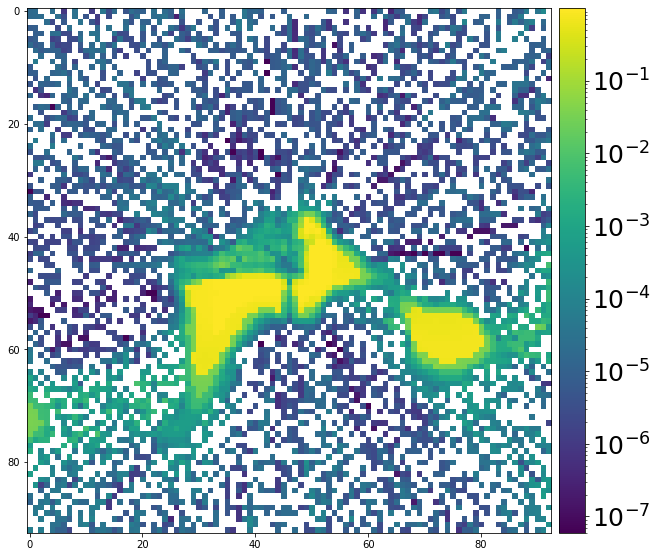

In [241]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-single_source_recomb_1e6['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

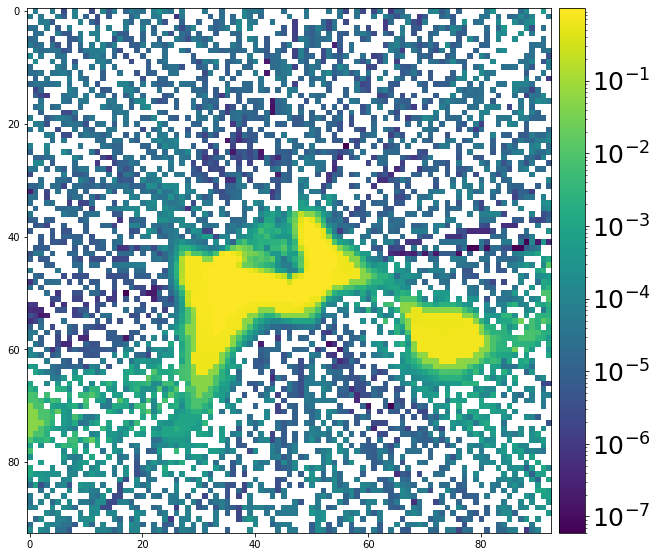

In [242]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-single_source_1e6['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

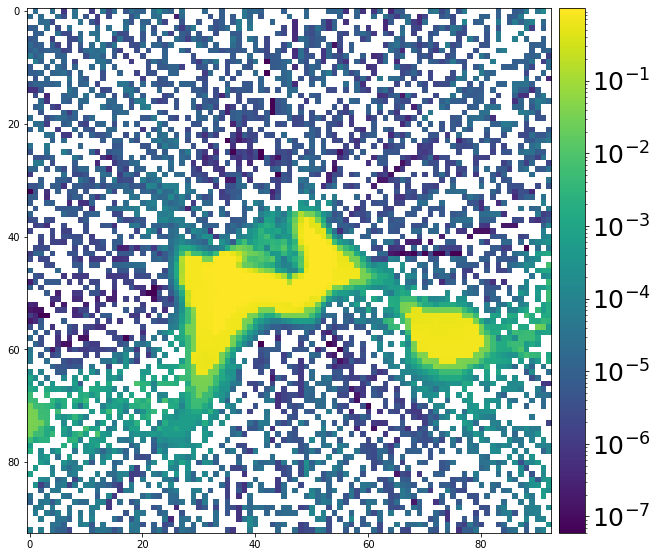

In [254]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-single_source_no_T_1e6['out']['T'][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

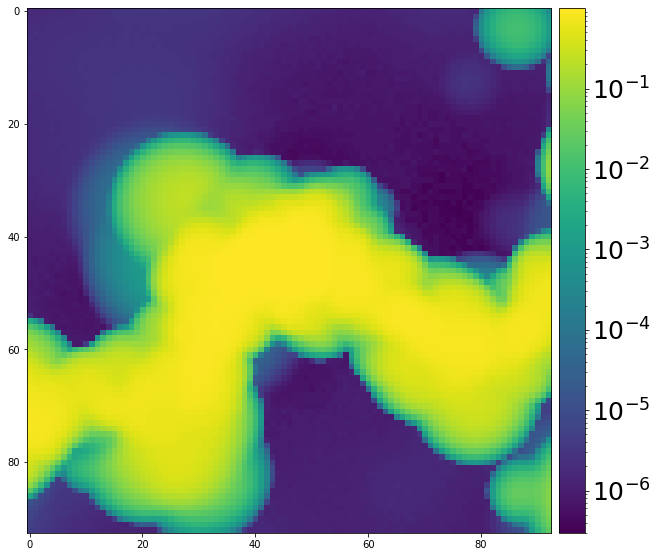

In [37]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(1-single_source_1e6_si['in'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-446-fc5d654dbf49>:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)


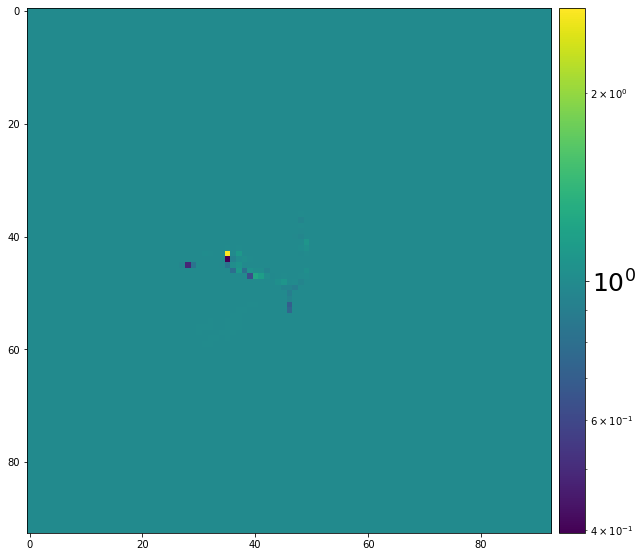

In [446]:
residual = (single_source_1e5['out'][prop]/single_source_1e5_si['out'][prop]/maps_1e5['out'][prop]
f, ax = plt.subplots(1, 1)
col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)
#subfig = ax.imshow(residual[cut],norm = col_norm)
subfig = ax.imshow(residual[cut],norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

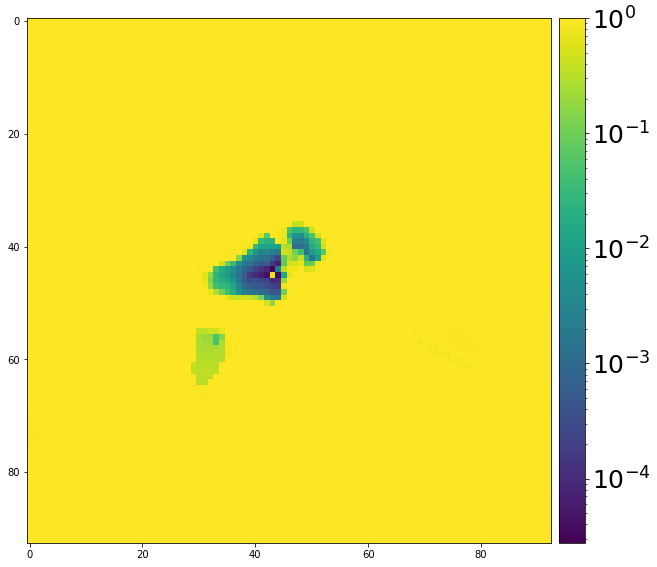

In [422]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_1e5_normal['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

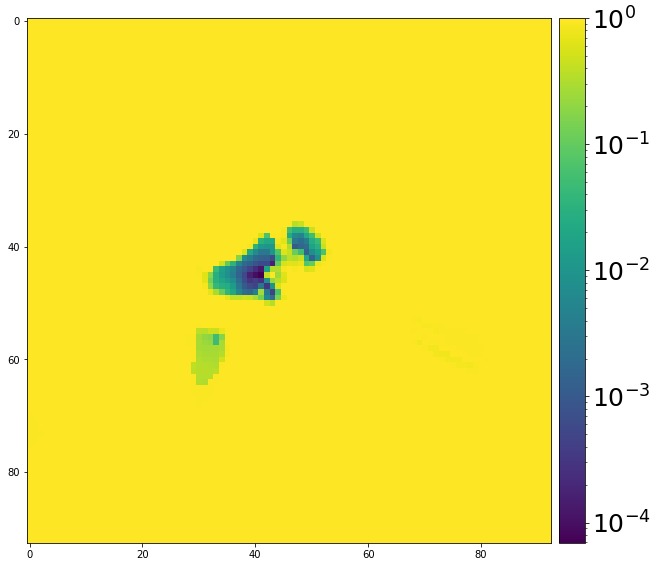

In [423]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_1e5_source_ionized['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

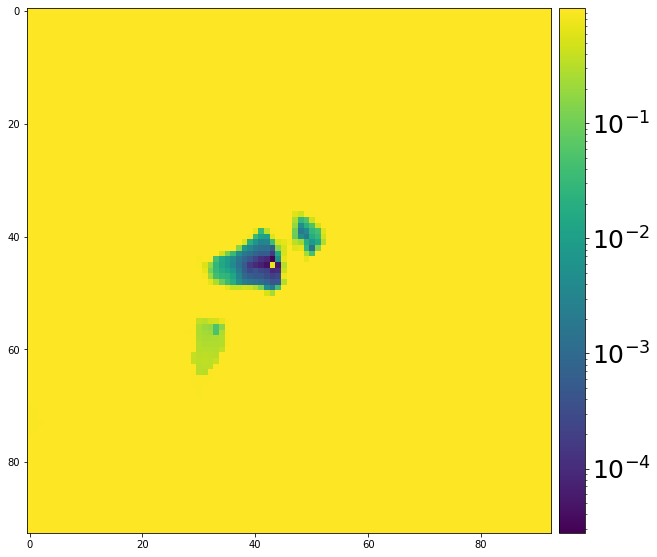

In [424]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_5e6_normal['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

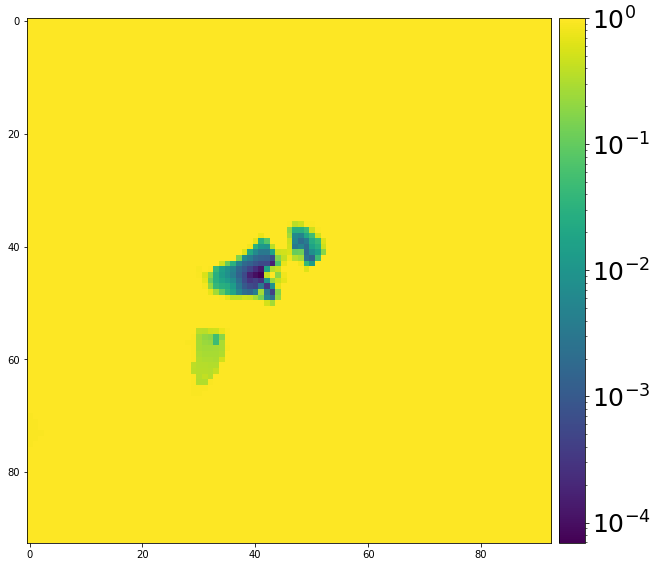

In [425]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_1e6_source_ionized['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-451-12de42836750>:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)


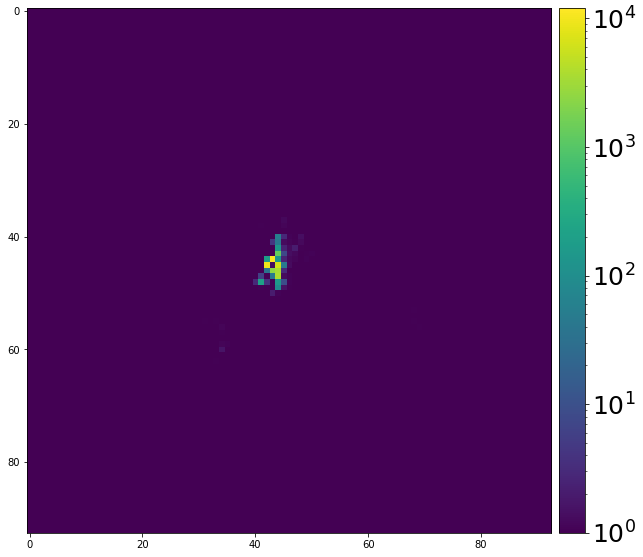

In [451]:
residual = (maps_1e5_source_ionized['out'][prop]/maps_1e5_normal['out'][prop])#/maps_1e5['out'][prop]
f, ax = plt.subplots(1, 1)
col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)
#subfig = ax.imshow(residual[cut],norm = col_norm)
subfig = ax.imshow(residual[cut],norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-427-9e3c1a633f0f>:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)


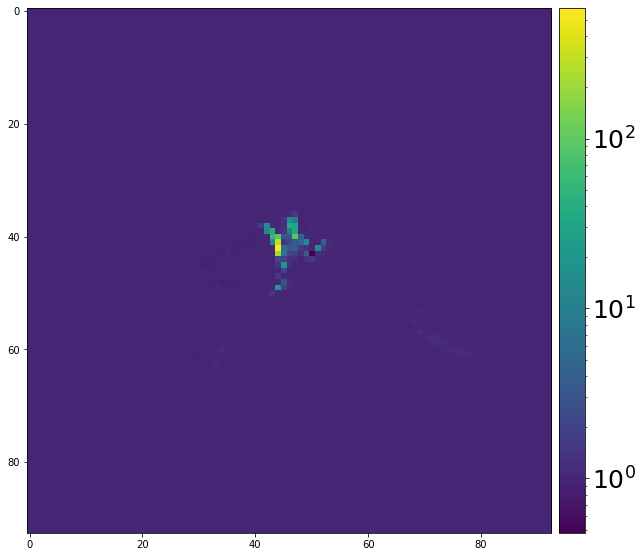

In [427]:
residual = (maps_5e6['out'][prop]/maps_1e5['out'][prop])#/maps_1e5['out'][prop]
f, ax = plt.subplots(1, 1)
col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)
#subfig = ax.imshow(residual[cut],norm = col_norm)
subfig = ax.imshow(residual[cut],norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

<ipython-input-432-a096961b8db1>:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)


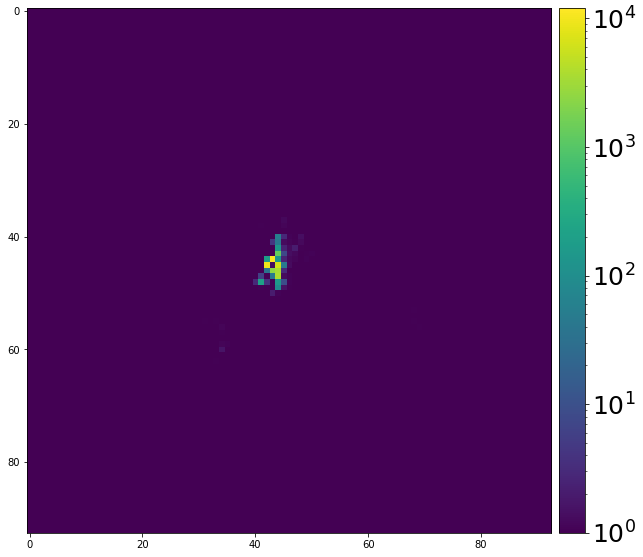

In [432]:
residual = (maps_1e5_source_ionized['out'][prop]/maps_1e5['out'][prop])#/maps_1e5['out'][prop]
f, ax = plt.subplots(1, 1)
col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)
#subfig = ax.imshow(residual[cut],norm = col_norm)
subfig = ax.imshow(residual[cut],norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

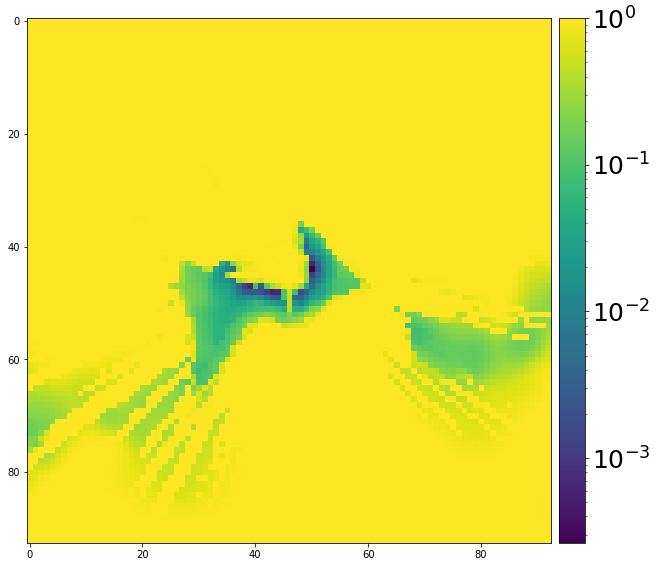

In [353]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(single_source_1e5['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

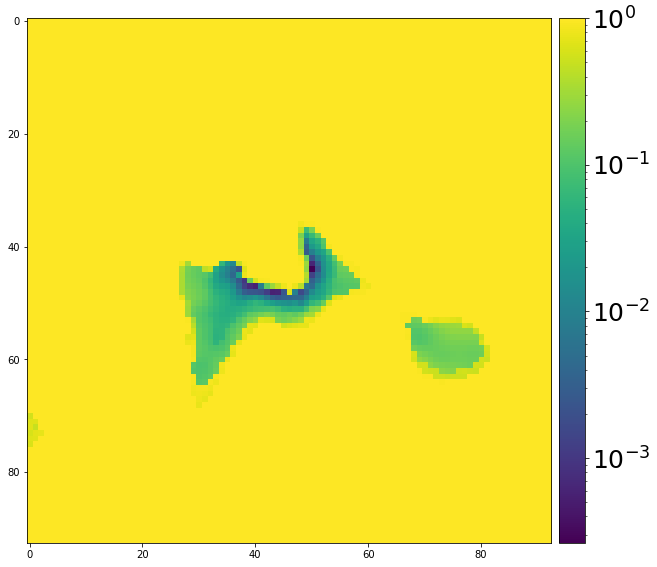

In [354]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(single_source_1e6['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

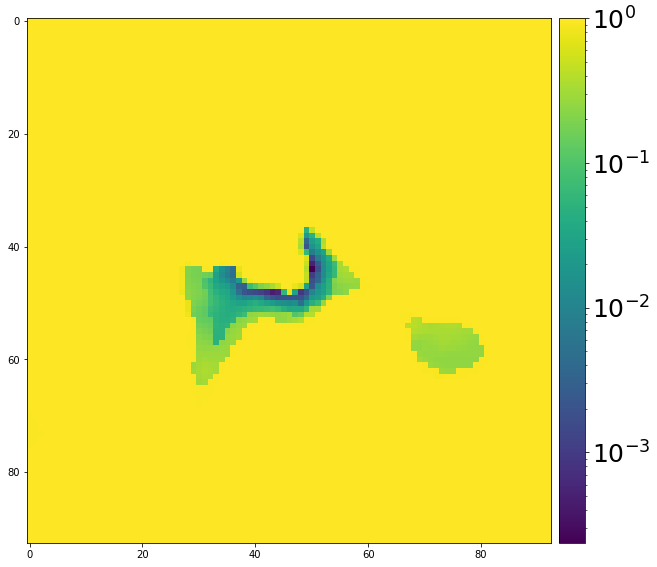

In [310]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(single_source_1e7['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

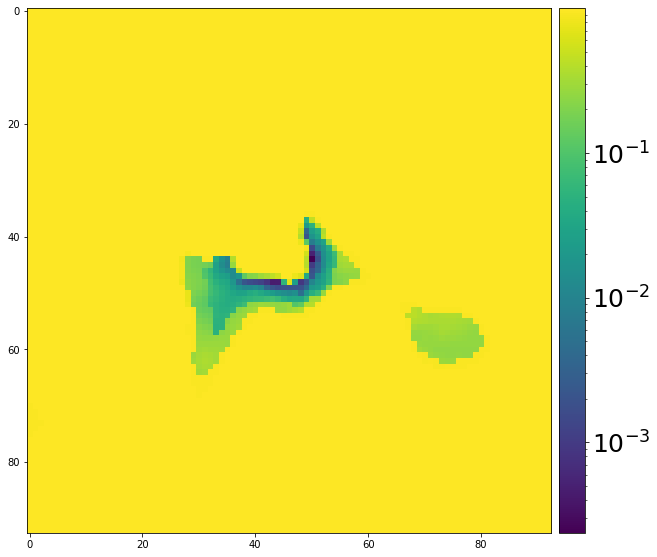

In [312]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(single_source_1e8['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

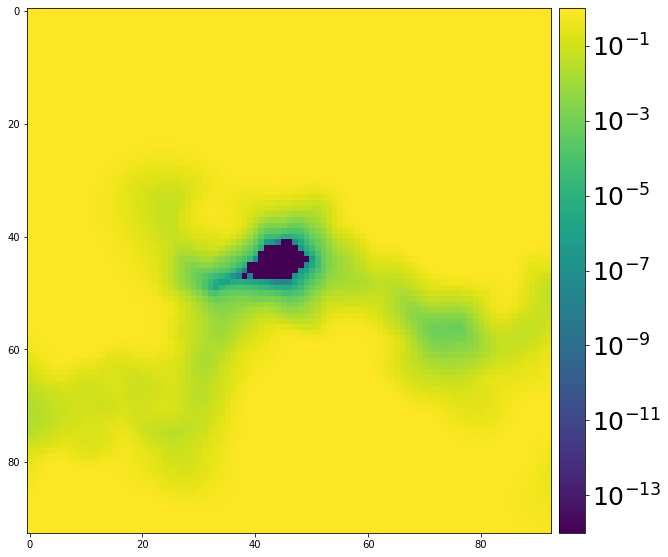

In [381]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_5e6['in'][prop][cut]+1e-14, norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [ ]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_5e6['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [ ]:
f, ax = plt.subplots(1, 1)
subfig = ax.imshow(maps_5e6['out'][prop][cut], norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [258]:
import matplotlib as mpl
from matplotlib import colors

<ipython-input-343-840daa3b1fb0>:1: RuntimeWarning: divide by zero encountered in true_divide
  residual = (single_source_1e5['out'][prop]/single_source_1e5['in'][prop])#/maps_1e5['out'][prop]
<ipython-input-343-840daa3b1fb0>:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)


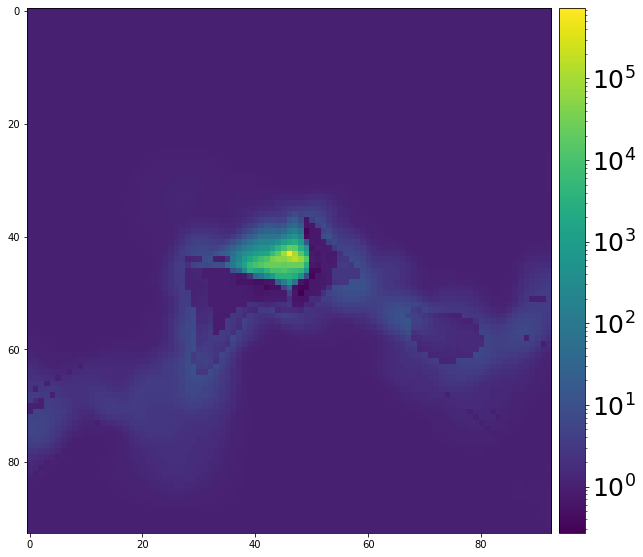

In [343]:
residual = (single_source_1e5['out'][prop]/single_source_1e5['in'][prop])#/maps_1e5['out'][prop]
f, ax = plt.subplots(1, 1)
col_norm = colors.DivergingNorm(vmin=0.9, vcenter=1., vmax=1.10)
#subfig = ax.imshow(residual[cut],norm = col_norm)
subfig = ax.imshow(residual[cut],norm = LogNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

In [46]:
np.average(residual)

-0.0061996332503666774

In [38]:
(np.sum(maps_5e6['out']['T'])-np.sum(maps_1e5['out']['T']))/np.sum(maps_1e5['out']['T'])

0.000120357996

In [42]:
np.average(residual)
np.max(residual)
np.min(residual)

-0.0061996332503666774

0.9843139313161373

-0.9980633337981999

## maps_1_5 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/input/L35n270TNG/sn008/g1')
maps_1 = get_maps('/ptmp/mpa/mglatzle/TNG_f_esc/test2/input/L35n270TNG/sn008/g1')

In [ ]:
maps_649['in']['T'].max()
maps_649['in']['xHI'].mean()
maps_649['in']['T'].min()
maps_649['out']['T'].max()
maps_649['out']['xHI'].mean()
maps_649['out']['T'].min()

In [ ]:
plt.imshow(maps_1_5['dens'][32,...], norm = LogNorm());

In [38]:
maps_1['dens'][23,...].shape
maps_1_5['dens'][32,...].shape

(44, 44)

(65, 65)

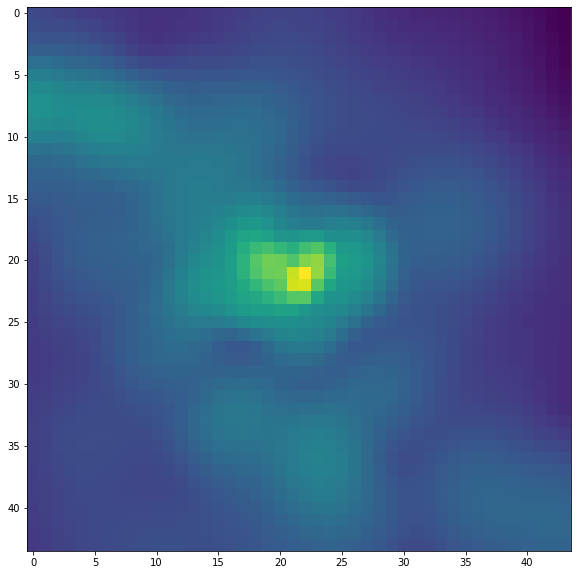

In [40]:
plt.imshow(maps_1['dens'][22,...], norm = LogNorm());

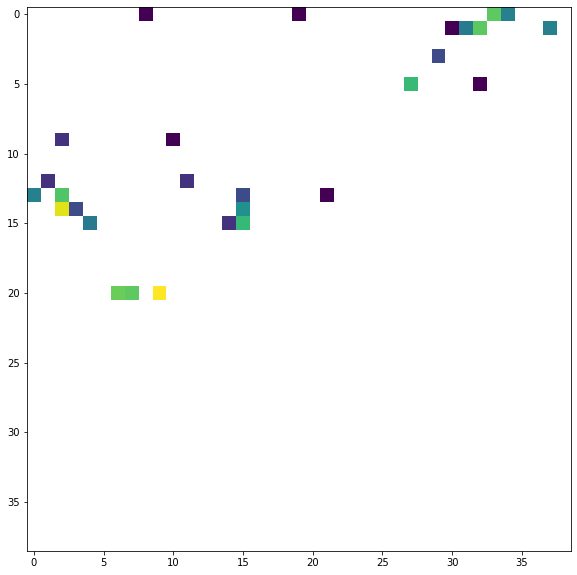

In [48]:
plt.imshow(maps_no_dust['out']['xHI'][15,...]-maps_dust['out']['xHI'][15,...], norm = LogNorm());

In [47]:
(maps_no_dust['out']['xHI']-maps_dust['out']['xHI']==0).all()

False